In [1]:
%matplotlib inline
# Import dev version of friedrich:
import sys
sys.path.insert(0, '../')

import numpy as np
import matplotlib.pyplot as plt
from friedrich.analysis import Transit, Spot, Measurement, MCMCResults
from friedrich.lightcurve import hat11_params_morris_is_90
from glob import glob

archive_paths = sorted(glob('/local/tmp/friedrich/hat11_is_90/chains???.hdf5'))
#archive_paths = sorted(glob('/local/tmp/friedrich/hat11_init/chains???.hdf5'))
print('load results')
transits = []
all_times = []
for archive_path in archive_paths:
    m = MCMCResults(archive_path, hat11_params_morris_is_90())
    all_times.extend(m.lc.times.jd)
    spots = m.get_spots()
    transits.append(Transit(spots))


load results


In [2]:
from friedrich.orientation import times_to_occulted_lat_lon
from friedrich.lightcurve import hat11_params_morris_is_90

transit_params = hat11_params_morris_is_90()
all_lats = []
all_lons = []
all_amps = []
all_lats_errors = []
all_spot_times = []
all_BICs = []
for transit in transits:
    for spot in transit.spots: 
        latitude, longitude = times_to_occulted_lat_lon(np.array([spot.t0.value]), 
                                                        transit_params)
        all_lats.append(latitude)
        all_lons.append(longitude)
        all_amps.append(spot.amplitude.value)
        all_spot_times.append(spot.t0.value)
        all_BICs.append(spot.delta_BIC)
        all_lats_errors.append(np.mean([spot.amplitude.upper, spot.amplitude.lower]))
all_lats = np.array(all_lats)
all_lats_errors = np.array(all_lats_errors)
all_lons = np.array(all_lons)
all_amps = np.array(all_amps)
all_spot_times = np.array(all_spot_times)
all_BICs = np.array(all_BICs)

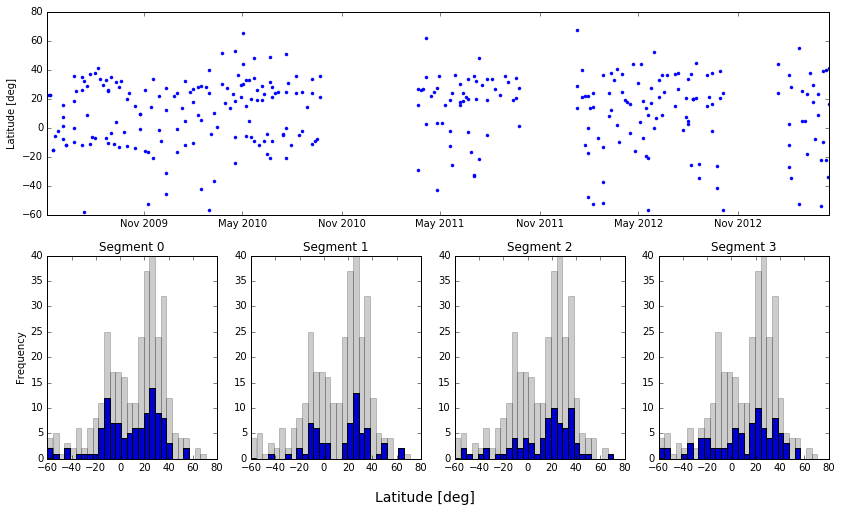

In [3]:
#all_amps
# plt.plot_date(Time(all_spot_times[all_BICs > 10], format='jd').plot_date, 
#               np.degrees(all_lats[all_BICs > 10]), '.')
from astropy.time import Time

n_panels = 4
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 4)
ax0 = plt.subplot(gs[0, :])
ax1 = [plt.subplot(gs[1, i]) for i in range(n_panels)]

#fig, ax = plt.subplots(1, n_panels, figsize=(14, 3))
first_spot = all_spot_times[all_BICs > 10].min()
last_spot = all_spot_times[all_BICs > 10].max()
first_to_last = last_spot - first_spot
fraction_gt_median = np.zeros(n_panels)

ax0.plot_date(Time(all_spot_times[all_BICs > 10], format='jd').plot_date, 
              np.degrees(all_lats[all_BICs > 10]), '.')

for i in range(n_panels):
    extent = [-60, 80]
    within_time_bin = ((all_spot_times[all_BICs > 10] - first_spot > 
                        i/n_panels*first_to_last) & 
                       (all_spot_times[all_BICs > 10] - first_spot < 
                        (i+1)/n_panels*first_to_last))
    lats_in_time_bin = np.degrees(all_lats[all_BICs > 10][within_time_bin])
    ax1[i].hist(lats_in_time_bin, 30, range=extent)

    ax1[i].hist(np.degrees(all_lats[all_BICs > 10]), 30,
                range=extent, alpha=0.2, color='k', zorder=10)

    ax1[i].set_xlim(extent)
    
    ax1[i].set(title='Segment {0}'.format(i))
    
    if i == 0:
        segment_zero_mean = np.median(lats_in_time_bin)
    fraction_gt_median[i] = np.count_nonzero(lats_in_time_bin > segment_zero_mean)/len(lats_in_time_bin)

ax1[0].set_ylabel('Frequency')
ax0.set_ylabel('Latitude [deg]')

fig.text(0.5, 0.05, 'Latitude [deg]', ha='center', fontsize=14)

#fig.subplots_adjust()

In [4]:
ignore_high_latitudes = ((all_lats > np.radians(-40)) & (all_lats < np.radians(50)))
significance_cutoff = np.atleast_2d(all_BICs > 10).T
significant_latitudes = np.degrees(all_lats[significance_cutoff & ignore_high_latitudes])

#significant_latitudes_errors = np.degrees(np.atleast_2d(all_lats_errors).T[significance_cutoff & ignore_high_latitudes])
significant_latitudes_errors = np.ones_like(significant_latitudes) * 2

# Gaussian mixture model with scikit-learn

Note that it is not well physically motivated to model the distribution as three gaussians, because while it may be a good approximation to model the active latitudes with Gaussians, the perhaps uniform background of spots distributed isotropically on the surface of the star would be modeled with a cosine function.  

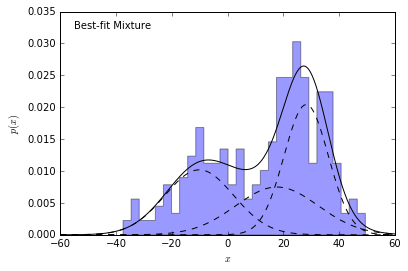

In [5]:
from sklearn.mixture import GMM

X = np.atleast_2d(significant_latitudes).T

fig, ax = plt.subplots()
M_best = GMM(3).fit(X)#models[np.argmin(AIC)]

x = np.atleast_2d(np.linspace(-60, 60, 1000)).T
# logprob, responsibilities = M_best.eval(x)
logprob = M_best.score(x)
responsibilities = M_best.predict_proba(x)

pdf = np.exp(logprob)
pdf_individual = responsibilities * pdf[:, np.newaxis]

ax.hist(X, 30, normed=True, histtype='stepfilled', alpha=0.4)
ax.plot(x, pdf, '-k')
ax.plot(x, pdf_individual, '--k')
ax.text(0.04, 0.96, "Best-fit Mixture",
        ha='left', va='top', transform=ax.transAxes)
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')

# Implement a Gaussian Mixture Model with `emcee`

In [6]:
from scipy.integrate import quad
quad(lambda x: np.cos(2*x), -np.pi/4, np.pi/4)

(1.0, 1.1102230246251565e-14)

In [7]:
import emcee
from scipy.misc import logsumexp

def gaussian(x, mean, lnvar, amp):
    var = np.exp(lnvar)
    return amp/np.sqrt(2*np.pi*var) * np.exp(-0.5 * (x - mean)**2 / var)

def cosine(x, x0, amp):
    y = amp * np.cos(2*np.radians(x - x0))
    visible_hemisphere = (-45 < x - x0) & (x - x0 < 45)
    y[~visible_hemisphere] = 0
    return y

def lnlikelihood_gaussian(x, yerr, mean, lnvar, amp):
    var = np.exp(lnvar) + yerr**2
#     return  -0.5 * (x - mean)**2 / var - 0.5 * np.log(2*np.pi*var) + np.log(amp)
    return  -0.5 * ((x - mean)**2 / var + np.log(var)) + np.log(amp)

def lnlikelihood_cosine(x, yerr, x0, amp):
    #return np.log(cosine(x, x0, amp))
    return -0.5 * (((cosine(x, x0, amp) - x) / yerr)**2 + 2*np.log(yerr))
    
def lnlikelihood_sum_gaussians(parameters, x, yerr):
    a1, m1, s1, a2, m2, s2 = parameters
    a3 = 1 #- a1 - a2
    x0 = (m1+m2)/2
#     ln_likes = (lnlikelihood_gaussian(x, yerr, m1, s1, a1),
#                 lnlikelihood_gaussian(x, yerr, m2, s2, a2),
#                 lnlikelihood_cosine(x, yerr, x0, a3))

    ln_likes = (np.logaddexp(lnlikelihood_cosine(x, yerr, x0, a3), lnlikelihood_gaussian(x, yerr, m1, s1, a1)),
                np.logaddexp(lnlikelihood_cosine(x, yerr, x0, a3), lnlikelihood_gaussian(x, yerr, m2, s2, a2)))
    return np.sum(np.logaddexp.reduce(ln_likes)), ln_likes

def minimize_this(parameters, x, yerr):
    return -1*lnlikelihood_sum_gaussians(parameters, x, yerr)

def model(parameters, x):
    a1, m1, s1, a2, m2, s2 = parameters
    a3 = 1 # - a1 - a2
    x0 = (m1+m2)/2
    return (cosine(x, x0, a3) * gaussian(x, m1, s1, a1) + 
            cosine(x, x0, a3) * gaussian(x, m2, s2, a2))
#     return (gaussian(x, m1, s1, a1) + 
#             gaussian(x, m2, s2, a2) + 
#             cosine(x, x0, a3))

def lnprior(parameters):
    a1, m1, s1, a2, m2, s2 = parameters
    variances = np.exp([s1, s2])
    means = np.array([m1, m2])
    
    if (a1 <= 1 - a2 and a2 <= 1 - a1 and 0 <= a1 <= 1 and 0 <= a2 <= 1 and 
        np.all(variances < 50**2) and np.all(variances > 0) and
        np.all(-50 < means) and np.all(means < 50) and m1 < m2):
        return 0.0
    return -np.inf

def lnprob(parameters, x, yerr):
    lp = lnprior(parameters)
    if not np.isfinite(lp):
        return -np.inf, None
    lnlike, blobs = lnlikelihood_sum_gaussians(parameters, x, yerr)
    return lp + lnlike, blobs

initp = [0.4, -10, np.log(9**2), 0.5, 28, np.log(9**2)]

ndim, nwalkers = len(initp), 4*len(initp)
p0 = [np.array(initp) + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, 
                                args=(significant_latitudes, significant_latitudes_errors),
                                threads=4)

pos = sampler.run_mcmc(p0, 500)[0]
samples = sampler.run_mcmc(pos, 15000)

[  0.27171737 -15.43457325   4.42723137   0.7250323   26.45380259
   4.38781126]


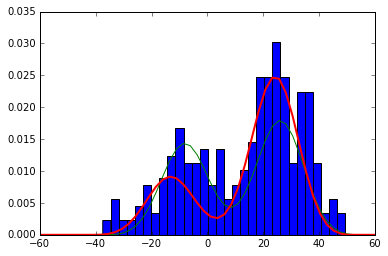

In [8]:
burnin = 10000
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

bestp = np.median(samples, axis=0)

plt.hist(significant_latitudes, 30, normed=True)
test_lats = np.linspace(-60, 60)
plt.plot(test_lats, model(initp, test_lats))
plt.plot(test_lats, model(bestp, test_lats), lw=2)
print(bestp)

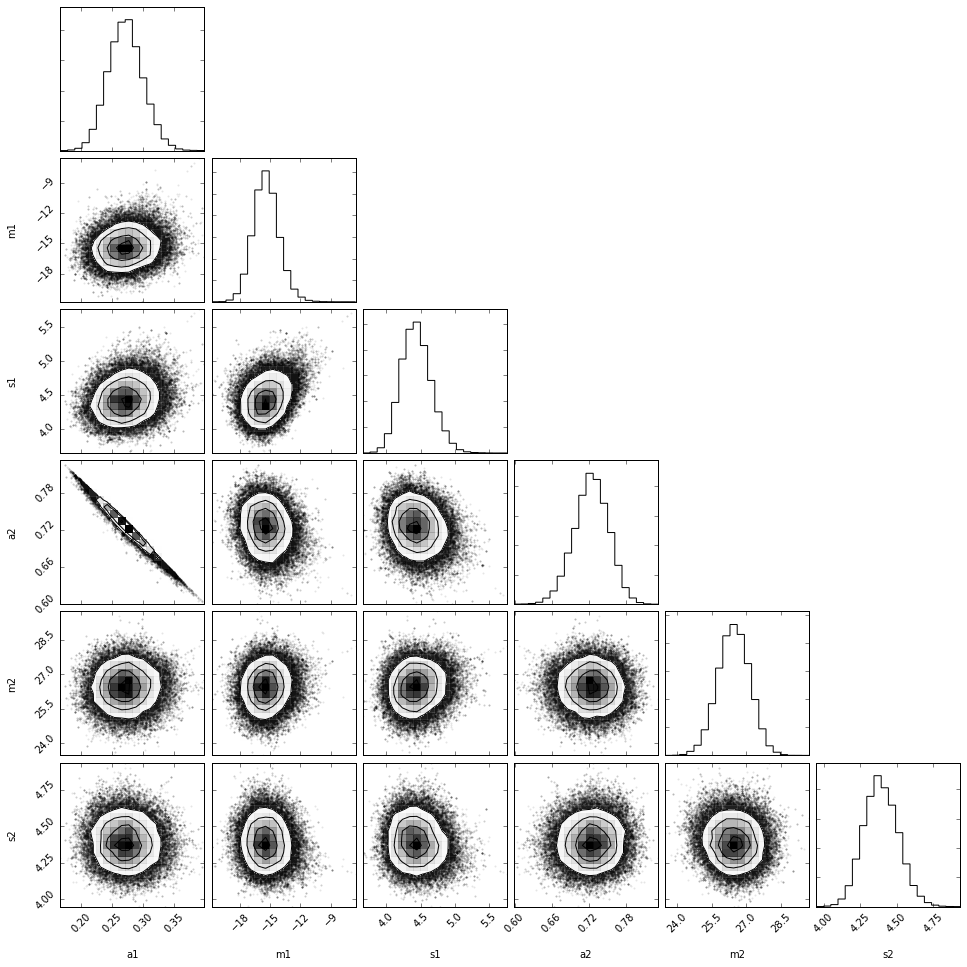

In [9]:
import corner 

labels = "a1, m1, s1, a2, m2, s2".split(', ')
fig = corner.corner(samples, labels=labels)

0.271717373495 0.725032304299 0.00325032220552


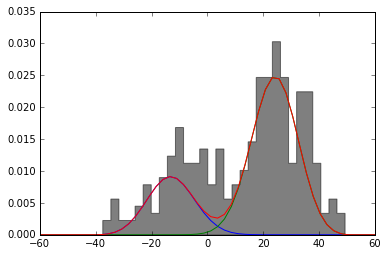

In [17]:
components = np.array([gaussian(test_lats, bestp[1], bestp[2], bestp[0]), 
                       gaussian(test_lats, bestp[4], bestp[5], bestp[3])]).T


components = np.array([gaussian(test_lats, bestp[1], bestp[2], bestp[0]) * cosine(test_lats, (bestp[1] + bestp[4])/2, 1), 
                       gaussian(test_lats, bestp[4], bestp[5], bestp[3]) * cosine(test_lats, (bestp[1] + bestp[4])/2, 1)]).T

                       #cosine(test_lats, (bestp[1] + bestp[4])/2, 1-bestp[0]-bestp[3])]).T
#                        cosine(test_lats, (initp[1] + initp[4])/2, 1-initp[0]-initp[3])]).T
print(bestp[0], bestp[3], 1-bestp[0]-bestp[3])
plt.hist(significant_latitudes, 30, normed=True, alpha=0.5, histtype='stepfilled', color='k')

plt.plot(test_lats, components)
plt.plot(test_lats, model(bestp, test_lats))
plt.show()